# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Autoencoder for MNIST example

In [1]:
# imports and inits
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
h2o.init()

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm77pwnep
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm77pwnep/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm77pwnep/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,2 months and 18 days
H2O cluster name:,H2O_from_python_phall_hpeg44
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Import training data and assign all pixel columns to be inputs 

In [2]:
train = h2o.import_file('../data/train.csv')
X = [name for name in train.columns if name != 'label']

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Train five level stacked denoising autoencoder model

In [3]:
sdae = H2ODeepLearningEstimator(
    epochs=3,                                              
    hidden=[250, 50, 2, 50, 250],                          # 5 layers, 2 in the middle for viz
    activation='rectifier',                                     
    l2=0.2,                                                # L2 for numeric stability and can help with plotting rectifier activations
    adaptive_rate=True,
    sparse=True,                                           # handles data w/ many zeros more efficiently
    seed=88888,                                            # enables exact reproducibility
    reproducible=True,                                     # slow
    ignore_const_cols=True,
    autoencoder=True)
                                                     
sdae.train(x=X, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


#### Extract and display deep features

In [4]:
deep_features = sdae.deepfeatures(train, 2)
deep_features_pandas = deep_features.as_data_frame()
deep_features_pandas['label'] = train['label'].as_data_frame()
deep_features_pandas.head()

deepfeatures progress: |██████████████████████████████████████████████████| 100%


,DF.L3.C1,DF.L3.C2,label
0,1.779824,4.703854,2
1,10.836837,20.022569,3
2,0.206260,4.710994,0
3,0.608692,1.178580,0
4,1.977406,0.917825,2


#### Display 1's and 7's in extracted feature space
* 1's and 7's are typically hard to separate from one another
* The 2-D plot below shows some overlap

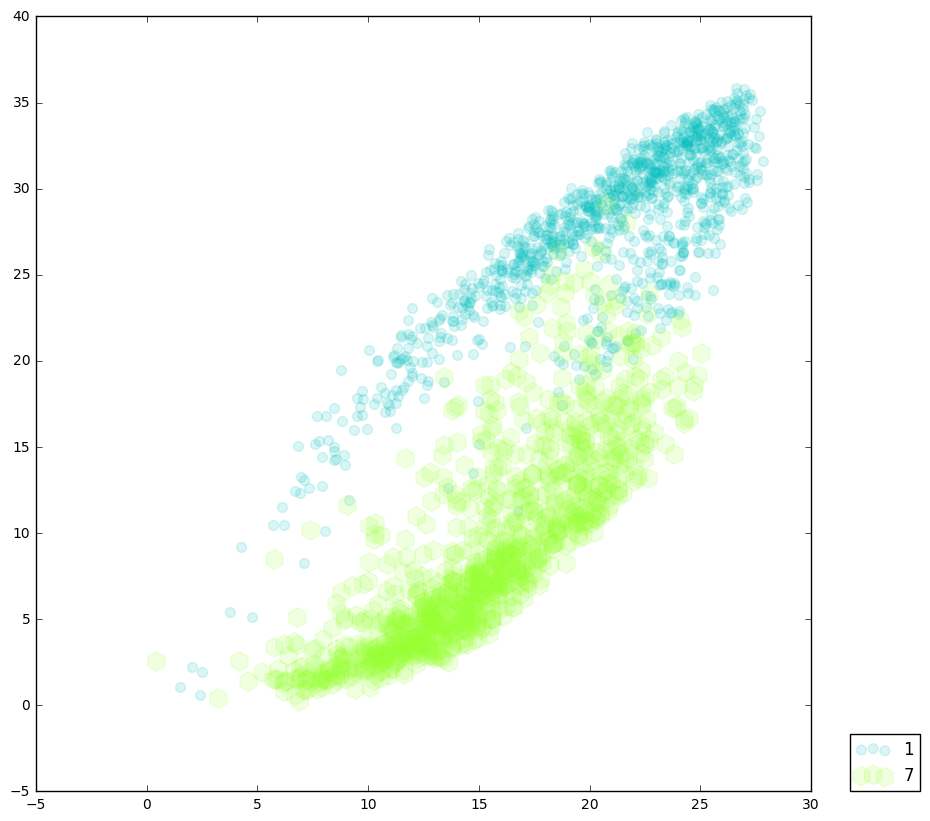

In [5]:
x_label = 'DF.L3.C1'
y_label = 'DF.L3.C2'
samp = 10000 # show first 10000

# figure size
plt.figure(figsize=(10,10), dpi = 300)

# baseline marker size
s = 100

# plot each number with different visual attributes

_1 = plt.scatter(deep_features_pandas[deep_features_pandas.label == 1].loc[0:samp:, x_label], 
           deep_features_pandas[deep_features_pandas.label == 1].loc[0:samp, y_label],
           color='c', s=s/2, alpha=.15)

_7 = plt.scatter(deep_features_pandas[deep_features_pandas.label == 7].loc[0:samp:, x_label], 
           deep_features_pandas[deep_features_pandas.label == 7].loc[0:samp, y_label],
           color='#99ff33', s=2*s, marker='h', alpha=.15)

# legend
_ = plt.legend([_1, _7], 
               ['1','7'], 
               bbox_to_anchor=(1.05, 0.0), 
               loc=3, borderaxespad=0.)


#### Use reconstruction error to find anomolous 1's

In [6]:
# h2o anomoly function calculates row-wise reconstrunction MSE
reconstruction_mse = sdae.anomaly(train[train['label'] == 1])

# use pandas to sort reconstrunction MSE
pandas_reconstruction_mse = reconstruction_mse.as_data_frame().sort_values(by='Reconstruction.MSE', ascending=False)
print(pandas_reconstruction_mse.head())
top = pandas_reconstruction_mse.idxmax().values[0]

      Reconstruction.MSE
809             0.203727
522             0.143500
2364            0.141046
2030            0.140258
3326            0.139653


#### Show most anomolous 1

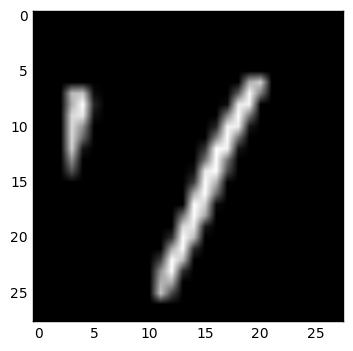

In [7]:
ones = train[train['label'] == 1].as_data_frame().as_matrix()
pixels = ones[top, 1:]
pixels = np.array(pixels, dtype='uint8')
pixels = pixels.reshape((28, 28))

plt.imshow(pixels, cmap='gray')
plt.show()

#### Use reconstruction error to find anomolous 7's

In [8]:
# h2o anomoly function calculates row-wise reconstrunction MSE
reconstruction_mse = sdae.anomaly(train[train['label'] == 7])

# use pandas to sort reconstrunction MSE
pandas_reconstruction_mse = reconstruction_mse.as_data_frame().sort_values(by='Reconstruction.MSE', ascending=False)
print(pandas_reconstruction_mse.head())
top = pandas_reconstruction_mse.idxmax().values[0]

      Reconstruction.MSE
3150            0.222543
4281            0.216492
1047            0.210677
1135            0.210584
1035            0.207671


#### Show most anomolous 7

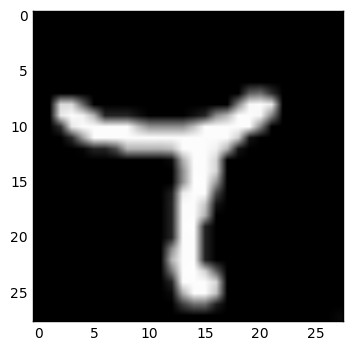

In [9]:
sevens = train[train['label'] == 7].as_data_frame().as_matrix()
pixels = sevens[top, 1:]
pixels = np.array(pixels, dtype='uint8')
pixels = pixels.reshape((28, 28))

plt.imshow(pixels, cmap='gray')
plt.show()

In [10]:
# shutdown h2o
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8411 closed.
